<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Задание 3

## Классификация текстов

В этом задании вам предстоит попробовать несколько методов, используемых в задаче классификации, а также понять насколько хорошо модель понимает смысл слов и какие слова в примере влияют на результат.

In [1]:
# !pip uninstall -y torchtext
# !pip install torchtext==0.8.1

# Импорт

In [2]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt
%matplotlib inline

import random
from tqdm.autonotebook import tqdm

# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

device = "cuda" if torch.cuda.is_available() else "cpu"

В этом задании мы будем использовать библиотеку torchtext. Она довольна проста в использовании и поможет нам сконцентрироваться на задаче, а не на написании Dataloader-а.

In [3]:
TEXT = Field(sequential=True, lower=True, include_lengths=True)  # Поле текста
LABEL = LabelField(dtype=torch.float)  # Поле метки

In [4]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Датасет на котором мы будем проводить эксперименты это комментарии к фильмам из сайта IMDB.

In [5]:
train, test = datasets.IMDB.splits(TEXT, LABEL)  # загрузим датасет
train, valid = train.split(random_state=random.seed(SEED))  # разобъём на части

In [6]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [7]:
train_iter, val_iter, test_iter = BucketIterator.splits(
    (train, valid, test), 
    batch_size=64,
    sort_within_batch=True,
    device=device
)

In [8]:
# функция отрисовки графика обучения
def plot_trainig(train_losses, val_losses):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.legend()

# RNN

Для начала попробуем использовать рекуррентные нейронные сети. На семинаре вы познакомились с GRU, вы можете также попробовать LSTM. Можно использовать для классификации как hidden_state, так и output последнего токена.

In [9]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [sent_len, batch_size]
        embedded = self.embedding(text)
        #embedded = [sent_len, batch_size, emb_dim]

        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        # cell arg for LSTM, remove for GRU
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)  

        #output = [sent_len, batch_size, hid_dim * num_directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num_layers * num_directions, batch_size, hid_dim]
        #cell = [num_layers * num_directions, batch_size, hid_dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        #hidden = [batch_size, hid_dim * num_directions]    
        
        return self.fc(hidden).flatten()

## Функции обучения и теста

In [10]:
def train_rnn(model, optimizer, criterion, dl_train, dl_val, num_epochs, max_grad_norm=2):
    train_losses, val_losses = [], []
    n_train = len(dl_train)
    n_val = len(dl_val)
    
    min_loss = np.inf
    cur_patience = 0
    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        model.train() #train mode
        for batch in dl_train:          
            x_batch = batch.text[0].to(device)
            y_batch = batch.label.to(device)

            optimizer.zero_grad()

            outputs = model(x_batch, text_lengths=batch.text[1].cpu())
            loss = criterion(outputs, y_batch)
            loss.backward()
            train_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

        train_loss /= n_train

        val_loss = 0.0
        model.eval() #val mode
        with torch.no_grad():
            for batch in dl_val:
                x_batch = batch.text[0].to(device)
                y_batch = batch.label.to(device)

                outputs = model(x_batch, text_lengths=batch.text[1].cpu())
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= n_val
        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if val_loss < min_loss:
            min_loss = val_loss
            best_model = model.state_dict()
            cur_patience = 0
        else:
            cur_patience += 1
            if cur_patience == 3:
                print("stopped")
                break
   
    model.load_state_dict(best_model)
    return train_losses, val_losses

def test_rnn(model, criterion, dl_test):
    n_test = len(dl_test)
    test_loss = 0.0
    true_list, pred_list = [], []

    model.eval() #val mode
    with torch.no_grad():
        for batch in dl_test:
            x_batch = batch.text[0].to(device)
            y_batch = batch.label.to(device)

            outputs = model(x_batch, text_lengths=batch.text[1].cpu())
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            outputs = outputs.detach()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).type(torch.long).cpu()

            true_list.append(y_batch.detach().cpu())
            pred_list.append(preds)

    y_true = torch.cat(true_list, dim=0)
    y_pred = torch.cat(pred_list, dim=0)

    test_loss /= n_test
    test_score = f1_score(y_true, y_pred)
    print('Test Loss: {:.4f}, Test Score: {:.4f}'.format(test_loss, test_score))

## Обучение

In [11]:
model = RNNBaseline(vocab_size=len(TEXT.vocab),
                    embedding_dim=100,
                    hidden_dim=256,
                    output_dim=1,
                    n_layers=2,
                    bidirectional=True,
                    dropout=0.2,
                    pad_idx=TEXT.vocab.stoi[TEXT.pad_token]
        ).to(device)

Epoch: 1, Train Loss: 0.6361, Val Loss: 0.5630
Epoch: 2, Train Loss: 0.5265, Val Loss: 0.5301
Epoch: 3, Train Loss: 0.4214, Val Loss: 0.5109
Epoch: 4, Train Loss: 0.3370, Val Loss: 0.4719
Epoch: 5, Train Loss: 0.2756, Val Loss: 0.4467
Epoch: 6, Train Loss: 0.2138, Val Loss: 0.5328
Epoch: 7, Train Loss: 0.1691, Val Loss: 0.5508
Epoch: 8, Train Loss: 0.1294, Val Loss: 0.6060
stopped


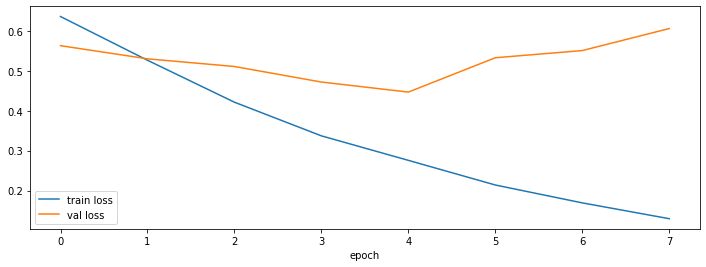

In [12]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

history = train_rnn(model, opt, criterion, train_iter, val_iter, num_epochs=20)
plot_trainig(*history)

Посчитайте f1-score вашего классификатора на тестовом датасете.

**Ответ**:

In [13]:
test_rnn(model, criterion, test_iter)

Test Loss: 0.5971, Test Score: 0.8022


# CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень хороший фильм" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно. Давайте попробуем!

In [14]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first т.к. мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

In [15]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key=lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False
)

Вы можете использовать Conv2d с `in_channels=1, kernel_size=(kernel_sizes[0], emb_dim))` или Conv1d c `in_channels=emb_dim, kernel_size=kernel_size[0]`. Но хорошенько подумайте над shape в обоих случаях.

In [16]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, out_channels, kernel_sizes, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        self.conv_0 = nn.Sequential(
            nn.Conv1d(emb_dim, out_channels, kernel_sizes[0]),
            nn.ReLU()
        )
        self.conv_1 = nn.Sequential(
            nn.Conv1d(emb_dim, out_channels, kernel_sizes[1]),
            nn.ReLU()
        )
        self.conv_2 = nn.Sequential(
            nn.Conv1d(emb_dim, out_channels, kernel_sizes[2]),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 1)
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.permute(0, 2, 1)
        
        conved_0 = self.conv_0(embedded)
        conved_1 = self.conv_1(embedded)
        conved_2 = self.conv_2(embedded)
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return self.fc(cat).flatten()

## Функции обучения и теста

In [17]:
def train_cnn(model, optimizer, criterion, dl_train, dl_val, num_epochs, max_grad_norm=2):
    train_losses, val_losses = [], []
    n_train = len(dl_train)
    n_val = len(dl_val)
    
    min_loss = np.inf
    cur_patience = 0
    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        model.train() #train mode
        for batch in dl_train:          
            x_batch = batch.text.to(device)
            y_batch = batch.label.to(device)

            optimizer.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            train_loss += loss.item()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

        train_loss /= n_train

        val_loss = 0.0
        model.eval() #val mode
        with torch.no_grad():
            for batch in dl_val:
                x_batch = batch.text.to(device)
                y_batch = batch.label.to(device)

                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= n_val
        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < min_loss:
            min_loss = val_loss
            best_model = model.state_dict()
            cur_patience = 0
        else:
            cur_patience += 1
            if cur_patience == 3:
                print("stopped")
                break
   
    model.load_state_dict(best_model)
    return train_losses, val_losses

def test_cnn(model, criterion, dl_test):
    n_test = len(dl_test)
    test_loss = 0.0
    true_list, pred_list = [], []

    model.eval() #val mode
    with torch.no_grad():
        for batch in dl_test:
            x_batch = batch.text.to(device)
            y_batch = batch.label.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            outputs = outputs.detach()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).type(torch.long).cpu()

            true_list.append(y_batch.detach().cpu())
            pred_list.append(preds)

    y_true = torch.cat(true_list, dim=0)
    y_pred = torch.cat(pred_list, dim=0)

    test_loss /= n_test
    test_score = f1_score(y_true, y_pred)
    print('Test Loss: {:.4f}, Test Score: {:.4f}'.format(test_loss, test_score))

## Обучение

In [18]:
model = CNN(vocab_size=len(TEXT.vocab),
            emb_dim=300,
            out_channels=100,
            kernel_sizes=(3, 4, 5),
            dropout=0.5,
            pad_idx=TEXT.vocab.stoi[TEXT.pad_token]
        ).to(device)

Epoch: 1, Train Loss: 0.7000, Val Loss: 0.5404
Epoch: 2, Train Loss: 0.5508, Val Loss: 0.4762
Epoch: 3, Train Loss: 0.4851, Val Loss: 0.4412
Epoch: 4, Train Loss: 0.4366, Val Loss: 0.4205
Epoch: 5, Train Loss: 0.3977, Val Loss: 0.4010
Epoch: 6, Train Loss: 0.3654, Val Loss: 0.3841
Epoch: 7, Train Loss: 0.3370, Val Loss: 0.3721
Epoch: 8, Train Loss: 0.3005, Val Loss: 0.3681
Epoch: 9, Train Loss: 0.2769, Val Loss: 0.3534
Epoch: 10, Train Loss: 0.2591, Val Loss: 0.3466
Epoch: 11, Train Loss: 0.2361, Val Loss: 0.3407
Epoch: 12, Train Loss: 0.2215, Val Loss: 0.3371
Epoch: 13, Train Loss: 0.1954, Val Loss: 0.3373
Epoch: 14, Train Loss: 0.1737, Val Loss: 0.3337
Epoch: 15, Train Loss: 0.1614, Val Loss: 0.3409
Epoch: 16, Train Loss: 0.1467, Val Loss: 0.3357
Epoch: 17, Train Loss: 0.1309, Val Loss: 0.3410
stopped


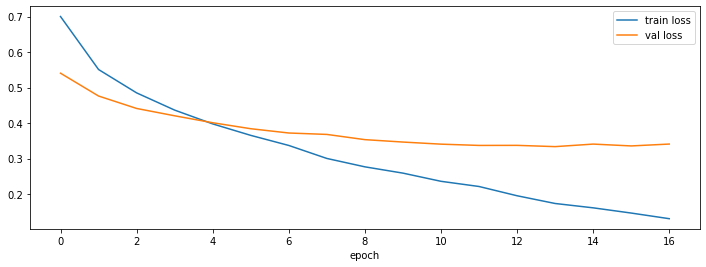

In [19]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

history = train_cnn(model, opt, criterion, train_iter, val_iter, num_epochs=30)
plot_trainig(*history)

Посчитайте f1-score вашего классификатора.

**Ответ**:

In [20]:
test_cnn(model, criterion, test_iter)

Test Loss: 0.3421, Test Score: 0.8609


# Интерпретируемость

Посмотрим, куда смотрит наша модель. Достаточно запустить код ниже.

In [21]:
!pip install -q captum

In [22]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)

In [23]:
def forward_with_softmax(inp):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))

# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len=7, label=0):
    print(sentence)
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, n_steps=5000, return_convergence_delta=True)
    print('pred: {} ({:.2f}), delta: {}\n'.format(LABEL.vocab.itos[pred_ind], pred, abs(delta.item())))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                                attributions,
                                pred,
                                LABEL.vocab.itos[pred_ind],
                                LABEL.vocab.itos[label],
                                LABEL.vocab.itos[1],
                                attributions.sum(),       
                                text,
                                delta))

In [24]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

It was a fantastic performance !
pred: pos (0.98), delta: 1.8878637703778622e-05

Best film ever
pred: pos (0.73), delta: 3.465993768891895e-05

Such a great show!
pred: pos (1.00), delta: 1.7818738227148856e-05

It was a horrible movie
pred: neg (0.40), delta: 2.253416005437714e-05

I've never watched something as bad
pred: neg (0.10), delta: 1.33384162026573e-05

It is a disgusting movie!
pred: pos (0.91), delta: 2.3077565078910567e-06



Попробуем ещё

In [25]:
interpret_sentence(model, 'This is How Movies Should Be Made', label=1)
interpret_sentence(model, 'I feel terrible', label=0)
interpret_sentence(model, 'Trash', label=0)
interpret_sentence(model, 'The greatest mob film still today', label=1)

This is How Movies Should Be Made
pred: pos (0.99), delta: 0.00011792183467207451

I feel terrible
pred: neg (0.20), delta: 1.3538084607134238e-05

Trash
pred: pos (0.91), delta: 1.1943108166212468e-05

The greatest mob film still today
pred: pos (0.91), delta: 1.1003498387340827e-05



In [26]:
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.98),pos,0.78,It was a fantastic performance ! pad
pos,pos (0.73),pos,-0.64,Best film ever pad pad pad pad
pos,pos (1.00),pos,0.80,Such a great show! pad pad pad
neg,neg (0.40),pos,-0.85,It was a horrible movie pad pad
neg,neg (0.10),pos,-1.06,I've never watched something as bad pad
neg,pos (0.91),pos,0.16,It is a disgusting movie! pad pad
pos,pos (0.99),pos,1.52,This is How Movies Should Be Made
neg,neg (0.20),pos,-0.90,I feel terrible pad pad pad pad
neg,pos (0.91),pos,1.00,Trash pad pad pad pad pad pad
pos,pos (0.91),pos,0.10,The greatest mob film still today pad


# Эмбэддинги слов

Вы ведь не забыли, как мы можем применить знания о word2vec и GloVe. Давайте попробуем!

In [27]:
TEXT.build_vocab(trn, vectors="glove.840B.300d")
LABEL.build_vocab(trn)

In [28]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

## Функция обучения

In [29]:
def set_req_grad_embedding(model, req_grad):
    for p in model.embedding.parameters():
        p.requires_grad = req_grad

def train_freeze(model, optimizer, criterion, dl_train, dl_val, num_epochs, max_grad_norm=2, num_freeze=10):
    train_losses, val_losses = [], []
    n_train = len(dl_train)
    n_val = len(dl_val)

    set_req_grad_embedding(model, False)
    is_frozen = True
    
    min_loss = np.inf
    cur_patience = 0
    for epoch in range(1, num_epochs + 1):
        if epoch > num_freeze and is_frozen:
            set_req_grad_embedding(model, True)
            is_frozen = False

        train_loss = 0.0
        model.train() #train mode
        for batch in dl_train:          
            x_batch = batch.text.to(device)
            y_batch = batch.label.to(device)

            optimizer.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            train_loss += loss.item()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

        train_loss /= n_train

        val_loss = 0.0
        model.eval() #val mode
        with torch.no_grad():
            for batch in dl_val:
                x_batch = batch.text.to(device)
                y_batch = batch.label.to(device)

                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= n_val
        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}, is_frozen: {}'.format(epoch, train_loss, val_loss, is_frozen))
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < min_loss:
            min_loss = val_loss
            best_model = model.state_dict()
            cur_patience = 0
        else:
            cur_patience += 1
            if cur_patience == 3:
                print("stopped")
                break
   
    model.load_state_dict(best_model)
    return train_losses, val_losses

## Обучение

In [30]:
model = CNN(vocab_size=len(TEXT.vocab),
            emb_dim=300,
            out_channels=100,
            kernel_sizes=(3, 4, 5),
            dropout=0.5,
            pad_idx=TEXT.vocab.stoi[TEXT.pad_token]
        )

In [ ]:
word_embeddings = TEXT.vocab.vectors
prev_shape = model.embedding.weight.shape
# инициализируем эмбэддинги
model.embedding.weight.data.copy_(word_embeddings)
assert prev_shape == model.embedding.weight.shape
model.to(device)
None

Epoch: 1, Train Loss: 0.5971, Val Loss: 0.4677, is_frozen: True
Epoch: 2, Train Loss: 0.4175, Val Loss: 0.3782, is_frozen: True
Epoch: 3, Train Loss: 0.3636, Val Loss: 0.3485, is_frozen: True
Epoch: 4, Train Loss: 0.3290, Val Loss: 0.3323, is_frozen: True
Epoch: 5, Train Loss: 0.3047, Val Loss: 0.3222, is_frozen: True
Epoch: 6, Train Loss: 0.2798, Val Loss: 0.3122, is_frozen: True
Epoch: 7, Train Loss: 0.2621, Val Loss: 0.3113, is_frozen: True
Epoch: 8, Train Loss: 0.2455, Val Loss: 0.3014, is_frozen: True
Epoch: 9, Train Loss: 0.2273, Val Loss: 0.2972, is_frozen: True
Epoch: 10, Train Loss: 0.2157, Val Loss: 0.2963, is_frozen: True
Epoch: 11, Train Loss: 0.1938, Val Loss: 0.2876, is_frozen: False
Epoch: 12, Train Loss: 0.1569, Val Loss: 0.2811, is_frozen: False
Epoch: 13, Train Loss: 0.1262, Val Loss: 0.2768, is_frozen: False
Epoch: 14, Train Loss: 0.0985, Val Loss: 0.2767, is_frozen: False
Epoch: 15, Train Loss: 0.0775, Val Loss: 0.2805, is_frozen: False
Epoch: 16, Train Loss: 0.0581

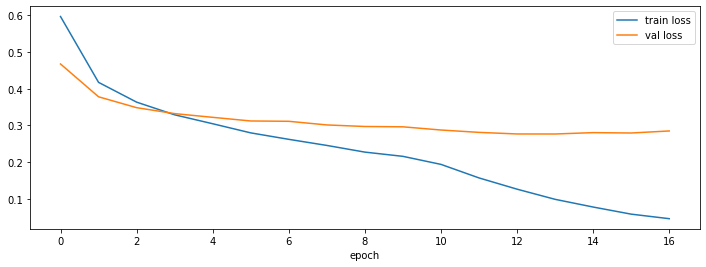

In [32]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

history = train_freeze(model, opt, criterion, train_iter, val_iter, num_epochs=30)
plot_trainig(*history)

Посчитайте f1-score вашего классификатора.

**Ответ**:

In [33]:
test_cnn(model, criterion, test_iter)

Test Loss: 0.2806, Test Score: 0.8887


Проверим насколько все хорошо!

In [34]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)
vis_data_records_ig.clear()

interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

It was a fantastic performance !
pred: pos (0.99), delta: 1.702707110950996e-05

Best film ever
pred: neg (0.21), delta: 1.1798972170518063e-05

Such a great show!
pred: pos (0.83), delta: 2.2202170491869566e-05

It was a horrible movie
pred: neg (0.01), delta: 0.00019056369157954833

I've never watched something as bad
pred: neg (0.41), delta: 3.502869302574041e-05

It is a disgusting movie!
pred: neg (0.00), delta: 9.86227047721222e-05



In [35]:
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(vis_data_records_ig)
None

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.99),pos,1.45,It was a fantastic performance ! pad
pos,neg (0.21),pos,0.70,Best film ever pad pad pad pad
pos,pos (0.83),pos,1.33,Such a great show! pad pad pad
neg,neg (0.01),pos,-0.74,It was a horrible movie pad pad
neg,neg (0.41),pos,1.29,I've never watched something as bad pad
neg,neg (0.00),pos,-0.79,It is a disgusting movie! pad pad
